In [16]:
import pickle
import numpy as np
from rekall.video_interval_collection import VideoIntervalCollection
from rekall.temporal_predicates import equal, overlaps
import matplotlib.pyplot as plt
from query.models import LabeledInterval, Labeler

# Load Conversations

In [3]:
videos = Video.objects.filter(ignore_film=False, year__gte=1935).exclude(
    genres__name="animation"
).order_by('id')

In [4]:
conversations = VideoIntervalCollection({
    video.id: pickle.load(open('/app/data/conversations/{}.pkl'.format(video.id), 'rb')).get_intervallist(video.id)
    for video in videos
})

# Analyze Precision and Recall of Conversations

In [5]:
conversations_gt_qs = LabeledInterval.objects.filter(labeler__name__contains="conversations")
conversations_gt = VideoIntervalCollection.from_django_qs(conversations_gt_qs)

In [12]:
conversations_in_gt_bounds = conversations.map(
    lambda intrvl: (intrvl.start, intrvl.end, 0)
).filter_against(
    conversations_gt,
    lambda conv, gt: conv.end < gt.end
).filter_against(
    conversations.filter_against(
        conversations_gt,
        lambda conv, gt: conv.start > gt.start
    ),
    equal()
)

In [14]:
# Returns precision, recall, precision_per_item, recall_per_item
def compute_statistics(query_intrvllists, ground_truth_intrvllists):
    total_query_time = 0
    total_query_segments = 0
    total_ground_truth_time = 0
    total_ground_truth_segments = 0
    
    for video in query_intrvllists:
        total_query_time += query_intrvllists[video].coalesce().get_total_time()
        total_query_segments += query_intrvllists[video].size()
    for video in ground_truth_intrvllists:
        total_ground_truth_time += ground_truth_intrvllists[video].coalesce().get_total_time()
        total_ground_truth_segments += ground_truth_intrvllists[video].size()
        
    total_overlap_time = 0
    overlapping_query_segments = 0
    overlapping_ground_truth_segments = 0
    
    for video in query_intrvllists:
        if video in ground_truth_intrvllists:
            query_list = query_intrvllists[video]
            gt_list = ground_truth_intrvllists[video]
            
            total_overlap_time += query_list.overlaps(gt_list).coalesce().get_total_time()
            overlapping_query_segments += query_list.filter_against(gt_list, predicate=overlaps()).size()
            overlapping_ground_truth_segments += gt_list.filter_against(query_list, predicate=overlaps()).size()
    
    if total_query_time == 0:
        precision = 1.0
        precision_per_item = 1.0
    else:
        precision = total_overlap_time / total_query_time
        precision_per_item = overlapping_query_segments / total_query_segments
    
    if total_ground_truth_time == 0:
        recall = 1.0
        recall_per_item = 1.0
    else:
        recall = total_overlap_time / total_ground_truth_time
        recall_per_item = overlapping_ground_truth_segments / total_ground_truth_segments
    
    return precision, recall, precision_per_item, recall_per_item

def print_statistics(query_intrvllists, ground_truth_intrvllists):
    precision, recall, precision_per_item, recall_per_item = compute_statistics(
        query_intrvllists, ground_truth_intrvllists)

    print("Precision: ", precision)
    print("Recall: ", recall)
    print("Precision Per Item: ", precision_per_item)
    print("Recall Per Item: ", recall_per_item)

In [17]:
print_statistics(conversations_in_gt_bounds.get_allintervals(), conversations_gt.get_allintervals())

Precision:  0.8014049166317166
Recall:  0.7490334903995625
Precision Per Item:  0.776536312849162
Recall Per Item:  0.837037037037037


# Analyze Conversation Screentime

In [75]:
# Average conversation time
average_conversation_proportions = [
    (Video.objects.get(id=video_id),
     float(conversations.get_intervallist(video_id).get_total_time()) / Video.objects.get(id=video_id).num_frames)
    for video_id in sorted(list(conversations.get_allintervals().keys()))
]

In [76]:
np.mean([conv for vid, conv in average_conversation_proportions])

0.41703374906643376

In [86]:
[(vid.title, conv) for vid, conv in average_conversation_proportions if conv < .07]

[('2001: A Space Odyssey', 0.06786990123514441),
 ('Gravity', 0.023129470016504675)]

In [77]:
len(average_conversation_proportions)

540

In [80]:
hitchcock_films = Video.objects.filter(directors__name="Alfred Hitchcock")

In [87]:
hitchcock_films.count()

35

In [81]:
np.mean([conv for vid, conv in average_conversation_proportions
         if vid in hitchcock_films])

0.5106541272701378

In [88]:
np.mean([conv for vid, conv in average_conversation_proportions
         if vid in Video.objects.filter(directors__name="Justin Lin")])

0.24295104505763582

In [71]:
def plot_avg_conversation_time_by_year(average_conversation_proportions, min_year=None, filename=None):
    data = sorted([(v.year, conversation_proportion) for v, conversation_proportion in average_conversation_proportions])
    if min_year is not None:
        data = [d for d in data if d[0] >= min_year]

    x = [d[0] for d in data]
    y = [d[1] for d in data]
    
    fig, ax = plt.subplots(figsize=(6.666, 3.333))
    fig.set_size_inches(6.666, 3.333)
    ax.set_xticks(range(1915, 2016, 25))
    ax.scatter(x, y, s=3, color='#4C4C4C')
    ax.set_ylim(0, 1)
    ax.set_xlabel('Year')
    ax.set_ylabel('Average Shot Duration (seconds)')
    ax.set_title('Average shot durations over time')
    
    #ax.set_yscale('symlog')
    
    ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 3))(np.unique(x)), color='#E41A1C')
#     ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    if filename is not None:
        plt.savefig(filename)
    plt.show()

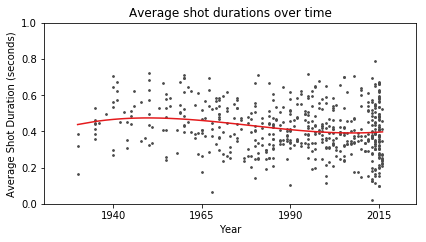

In [72]:
plot_avg_conversation_time_by_year(average_conversation_proportions, min_year=1930)